In [39]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5, 10, 9)
d2 = datetime(2021,9, 1,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)

In [40]:
pricedata.tail()

,timestamp,sqrtPriceX96,price
120400,1630457280,1355527382349696291973070296916222,0.000293
120401,1630457316,1355633495651790988012240522812889,0.000293
120402,1630457355,1356496723249880871370773228843790,0.000293
120403,1630457391,1356664209375015011561300805592324,0.000293
120404,1630457391,1357380036677709158041273101685800,0.000294


In [41]:
swapdata.tail()

,transactionHash,logIndex,transactionIndex,blockNumber,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,timestamp
120400,0xc09ae42dca6b4de56031ffa3b93ef324c582be7e8386...,58,50,13136626,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,-382861185806,112379947203796863973,1355527382349696291973070296916222,24781562554378302298,194957,1630457280
120401,0x2de3d0231e1a578e4ac350ca737bc6a1fa389cb6ca58...,38,46,13136629,0x27239549DD40E1D60F5B80B0C4196923745B1FD2,-113377666329,33290764904875893698,1355633495651790988012240522812889,24781562554378302298,194958,1630457316
120402,0x10dee28fa5d37a0867bf0cd4d8c8535335b5859611e2...,3,0,13136630,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,-921663835440,270819081680876423911,1356496723249880871370773228843790,24781562554378302298,194971,1630457355
120403,0xaa2b0c80e45290e6af9460b1f473e04b848302767ffb...,7,1,13136637,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,-178688247079,52545167350399362399,1356664209375015011561300805592324,24781562554378302298,194973,1630457391
120404,0xaab4697a35997998baf418fd595edd4aa5bf8bce948f...,69,21,13136637,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,-763207630466,224575411150770362168,1357380036677709158041273101685800,24781562554378302298,194984,1630457391


In [42]:
priceDf = pricedata
priceDf['datetime'] = list(map(lambda d: datetime.fromtimestamp(d), priceDf['timestamp'] ))
priceDt = priceDf.set_index('datetime')
priceDay = priceDt.resample('D').last()
priceDay['MA50'] = priceDay['price'].rolling(50).mean()
priceDay['Trend'] = priceDay['price']>=priceDay['MA50']
priceDay.index = list(map(lambda d: d.date(), priceDay.index))
priceDay

,timestamp,sqrtPriceX96,price,MA50,Trend
2021-05-10,1620662352,1228616988312226015357337899456895,0.000240,NaN,False
2021-05-11,1620748791,1252973529377508271162254629465828,0.000250,NaN,False
2021-05-12,1620834933,1222258371118313304597344053586746,0.000238,NaN,False
2021-05-13,1620921557,1295851047853606539736005287101923,0.000268,NaN,False
2021-05-14,1621007973,1232683723756514542155780026658030,0.000242,NaN,False
...,...,...,...,...,...
2021-08-28,1630166342,1392548055249243297576850278509046,0.000309,0.000396,False
2021-08-29,1630252324,1404463030442969386864663254788231,0.000314,0.000393,False
2021-08-30,1630339014,1397521323422833356024918066401034,0.000311,0.000390,False
2021-08-31,1630425506,1362563735141964888828555466967462,0.000296,0.000386,False


In [43]:
trendDict = dict(priceDay['Trend'])
priceDt['date'] = list(map(lambda d: d.date(), priceDt.index))
trendList = []
for i, v in priceDt.iterrows():
    trendList.append(trendDict[v['date']])
print(f'len of trendList:{len(trendList)}')
priceDt['trend'] = trendList

len of trendList:120405


In [44]:
priceDt

,timestamp,sqrtPriceX96,price,date,trend
datetime,,,,,
2021-05-10 09:17:52,1620609472,1267554519342589161168659854845874,0.000256,2021-05-10,False
2021-05-10 09:23:50,1620609830,1267498129839936824485169221023868,0.000256,2021-05-10,False
2021-05-10 09:24:49,1620609889,1267496927736336268048970777338285,0.000256,2021-05-10,False
2021-05-10 09:24:49,1620609889,1267496466129159558106023913391909,0.000256,2021-05-10,False
2021-05-10 09:24:54,1620609894,1267269382521328460205280017540103,0.000256,2021-05-10,False
...,...,...,...,...,...
2021-09-01 08:48:00,1630457280,1355527382349696291973070296916222,0.000293,2021-09-01,False
2021-09-01 08:48:36,1630457316,1355633495651790988012240522812889,0.000293,2021-09-01,False
2021-09-01 08:49:15,1630457355,1356496723249880871370773228843790,0.000293,2021-09-01,False


In [45]:
pricedata_res = pd.read_csv('../../data/usdceth/pricedata_res.csv',index_col=0) 
#pricedata_res 其实是处理过后的priceDt
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerQuantile75,CloseLowerMA,VolHigherQuantile50TwoSigma,revoke_pos
datetime,,,,,,,,
2021-05-10 09:17:52,1620609472,1267554519342589161168659854845874,0.000216,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:23:50,1620609830,1267498129839936824485169221023868,0.000049,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:24:49,1620609889,1267496927736336268048970777338285,0.000050,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:24:49,1620609889,1267496466129159558106023913391909,0.000051,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:24:54,1620609894,1267269382521328460205280017540103,0.000154,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2021-09-01 08:48:00,1630457280,1355527382349696291973070296916222,0.000057,1.0,0.0,0.0,0.0,0.0
2021-09-01 08:48:36,1630457316,1355633495651790988012240522812889,0.000193,1.0,0.0,0.0,0.0,0.0
2021-09-01 08:49:15,1630457355,1356496723249880871370773228843790,0.000092,1.0,0.0,0.0,0.0,0.0


In [46]:
pricedata_res['price'] = priceDt['price']
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerQuantile75,CloseLowerMA,VolHigherQuantile50TwoSigma,revoke_pos
datetime,,,,,,,,
2021-05-10 09:17:52,1620609472,1267554519342589161168659854845874,0.000256,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:23:50,1620609830,1267498129839936824485169221023868,0.000256,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:24:49,1620609889,1267496927736336268048970777338285,0.000256,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:24:49,1620609889,1267496466129159558106023913391909,0.000256,0.0,0.0,0.0,0.0,1.0
2021-05-10 09:24:54,1620609894,1267269382521328460205280017540103,0.000256,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2021-09-01 08:48:00,1630457280,1355527382349696291973070296916222,0.000293,1.0,0.0,0.0,0.0,0.0
2021-09-01 08:48:36,1630457316,1355633495651790988012240522812889,0.000293,1.0,0.0,0.0,0.0,0.0
2021-09-01 08:49:15,1630457355,1356496723249880871370773228843790,0.000293,1.0,0.0,0.0,0.0,0.0


In [47]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


In [48]:
import Strategy_usdceth_vol
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol)
strategy = Strategy_usdceth_vol.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  140631495516086534144
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.00033005978975935465
$$$$$$$【Lower Price】: 0.00019849777291908478
######【L】:60666448444272064【USDC】:449725000000【ETH】:117247551451873394688
将要投入池子的数量 amount_t0: 449725000000 amount_t1: 117247551451873165312
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=60665339031571984, tick=[191040, 196140], range=[3035.1064, 5054.2070])
【Mint amount】: token0=449708.399096, token1=117.24755145187316
Wallet amount: token0=16.600904, token1=23.38394406421337
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: 0.0, VolHigherQuantile50TwoSigma: 1.0
Price(0.00023134721414835757) out of range(0.00019849777291908478, 0.00033005978975935465)
【RealWorldTime

In [49]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x238d591b748>,
 2: <univ3api.simulation.PositionReport at 0x238cb9460b8>,
 3: <univ3api.simulation.PositionReport at 0x238cb95c0f0>}

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-25 22:57:11,462244.180929,0.000000,0.000000,0.000000,225.348,0.00000,0.00000,0.00000
1,2021-07-25 23:00:34,462570.753128,0.163286,0.163286,0.163286,225.194,0.00000,0.00000,0.00000
2,2021-07-25 23:00:41,462768.210759,0.098728,0.262014,0.262014,225.1,0.00000,0.00000,0.00000
3,2021-07-25 23:00:41,464409.142825,0.820466,1.082480,1.082480,224.325,0.00000,0.00000,0.00000
4,2021-07-25 23:01:22,465147.766752,0.369311,1.451791,1.451791,223.976,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...
7380,2021-08-05 06:01:42,988254.288640,0.096589,1688.369832,1688.369832,6.06504,0.00000,0.58902,0.58902
7381,2021-08-05 06:02:11,990281.615865,1.013663,1689.383495,1689.383495,5.32017,0.00000,0.58902,0.58902
7382,2021-08-05 06:02:11,990466.702796,0.092543,1689.476038,1689.476038,5.2522,0.00000,0.58902,0.58902
7383,2021-08-05 06:02:11,990486.756202,0.010026,1689.486064,1689.486064,5.24484,0.00000,0.58902,0.58902


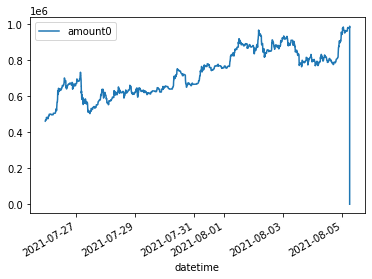

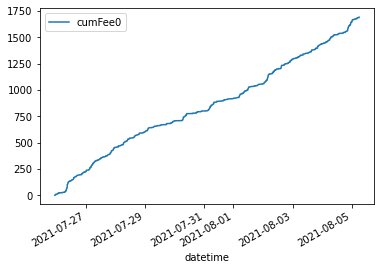

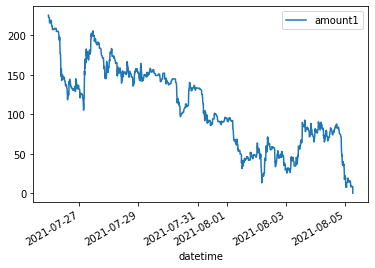

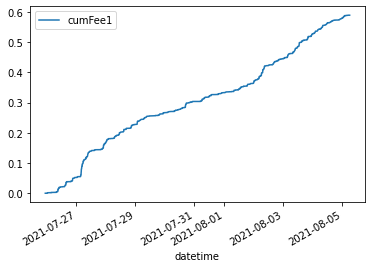

In [50]:
positions[2].get_balance(plain=True, draw_plot=True)

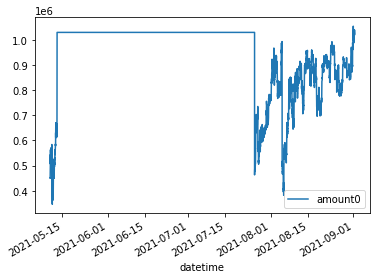

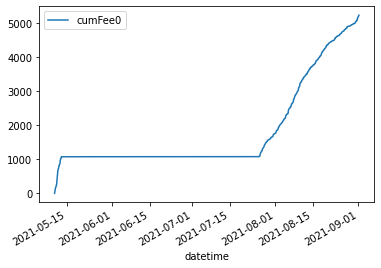

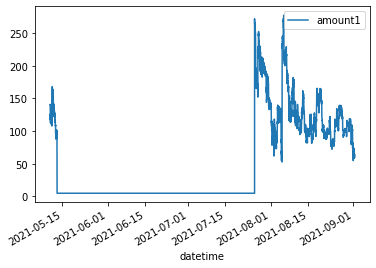

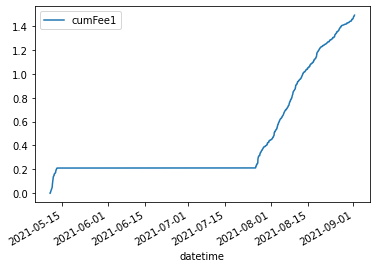

In [51]:
total_balance = report.total_balance(draw_plot=True, plain=True)

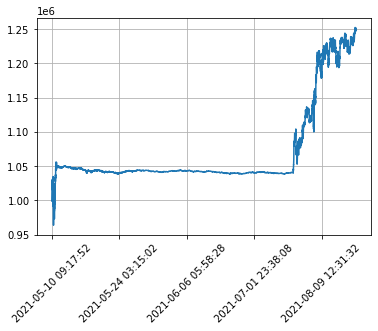

In [52]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True)
tb_Timing.to_csv('../../data/usdceth/tb_timing.csv')
tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin.csv')

In [53]:
eth_balance

timestamp
1620609472    549425.062949
1620609830    549305.247193
1620609889    549301.311704
1620609894    548818.966510
1620610623    549850.784613
                  ...      
1630457238    217095.265184
1630457280    218264.059471
1630457316    218610.053124
1630457355    221420.577460
1630457391    224525.665414
Length: 90237, dtype: float64

In [54]:
usdc_balance

timestamp
1620609472    4.497250e+05
1620609830    4.498939e+05
1620609889    4.498988e+05
1620609894    4.505790e+05
1620610623    4.491283e+05
                  ...     
1630457238    1.033398e+06
1630457280    1.032115e+06
1630457316    1.031736e+06
1630457355    1.028648e+06
1630457391    1.025493e+06
Length: 90237, dtype: float64